Found 630 images belonging to 21 classes.
Found 1470 images belonging to 21 classes.
Epoch 1/5
46/46 [==============================] - 21s 308ms/step - loss: 1.1967 - categorical_accuracy: 0.4064 - val_loss: 0.8605 - val_categorical_accuracy: 0.7381
Epoch 2/5
46/46 [==============================] - 12s 268ms/step - loss: 0.5815 - categorical_accuracy: 0.8840 - val_loss: 0.9459 - val_categorical_accuracy: 0.6937
Epoch 3/5
46/46 [==============================] - 12s 268ms/step - loss: 0.5501 - categorical_accuracy: 0.9012 - val_loss: 0.8418 - val_categorical_accuracy: 0.7444
Epoch 4/5
46/46 [==============================] - 12s 269ms/step - loss: 0.6005 - categorical_accuracy: 0.8699 - val_loss: 0.7493 - val_categorical_accuracy: 0.8016
Epoch 5/5
46/46 [==============================] - 12s 269ms/step - loss: 0.4396 - categorical_accuracy: 0.9587 - val_loss: 0.7240 - val_categorical_accuracy: 0.8095


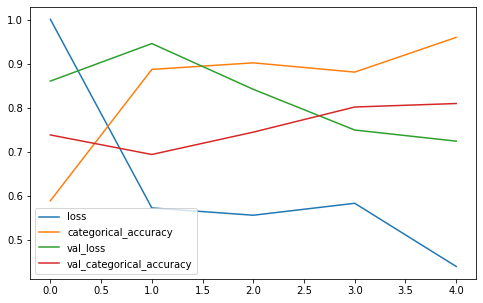

In [4]:
#In this notebook, we're going to try transfer learning for the first time.
#We'll be using the mercerImages as our test case.  Here, we have 2100 images,
#with 100 from each class.  This is too small of a dataset to meaningfully
#fit millions of parameters of a neural network.  So, instead we can use
#a similar neural network that has already been fit, and then try applying
#those weights to our case, just fine-tuning the end of the model.

#A good starting point for fine tuning models is to take a look at:
#https://tfhub.dev/tensorflow/resnet_50/feature_vector/1

#Note you may need to pip install --upgrade tensorflow_hub:
import keras
import pandas as pd
import tensorflow_hub as hub
from matplotlib import pyplot as plt

#In this example, we're going to use a ResNet50 that has already
#been classified using Imagenet.   The theory here is that the types
#of features that an algorithm detects to tell the difference between
#dogs, cats, boats, and houses are also likely similar to features
#that help our eyes detect differences between houses and airplanes
#in satellite imagery.  So, we use ImageNet as our starting point,
#and then tune based on our much smaller dataset.
dataGenerator = keras.preprocessing.image.ImageDataGenerator(validation_split=0.3, samplewise_center=True, fill_mode="nearest")

test = dataGenerator.flow_from_directory("./mercerImages", class_mode='categorical', 
                                            batch_size=32, subset="validation", 
                                            target_size=(224,224))
                                        
train = dataGenerator.flow_from_directory("./mercerImages", class_mode='categorical', 
                                        batch_size=32, subset="training", 
                                        target_size=(224,224))

#Note here we have a sequence of two layers - our KerasLayer, which is the pre-trained ResNet, and
#the Dense layer. The Dense layer takes the outputs from ResNet (512 filter values) and translates them into scores
#for our 21 mercerImages classes.
#In this block of code, trainable=True means the gradient backpropogates through the all layers - 
#if you set trainable to False, weights in the ResNet50 will never change.
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
                   trainable=True),  
    keras.layers.Dense(21, activation='softmax')
])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=.1),
                                            loss='categorical_hinge',
                                            metrics=['categorical_accuracy'])



modelHistory = model.fit(train, epochs=5, validation_data=test)

pd.DataFrame(modelHistory.history).plot(figsize=(8,5))
plt.show()